# Load Overlay

In [320]:
from pynq import Overlay
import numpy as np
from pynq import allocate
from time import sleep
from time import time as timer

overlay = Overlay('/home/xilinx/pynq/overlays/final_proj/guitar_effects_design_wrapper.bit')
overlay?

# Load in Audio Data

In [322]:
# load in audio file
import wave
import matplotlib.pyplot as plt
from scipy.io import wavfile

file_path = "./electric_guitar_sample.wav"

with wave.open(file_path, 'r') as wave_file:
    # get the number of frames
    n_frames = wave_file.getnframes()
    # read the frames
    full_frames = wave_file.readframes(n_frames)
    # convert frames to integers
    full_frames = np.frombuffer(full_frames, dtype=np.int16)
    
    # get the frame rate
    frame_rate = wave_file.getframerate()*2 # there are 2 samples per frame, so technically this is sample rate rather than frame rate
    # get the time values for the x axis
    full_time = np.linspace(0, len(full_frames) / frame_rate, num=len(full_frames))
    
#only use the first bit of frames so we can save ourselves some time
length = 1000000
frames = full_frames[:length]
time = full_time[:length]


# Define Input and Output Channels

In [323]:
# print(overlay.ip_dict)

guitar_effects = overlay.guitar_effects_0
dma = overlay.axi_dma_0

input = dma.sendchannel
output = dma.recvchannel

# Send Control Inputs through AXI-lite

In [358]:
# set all inputs and outputs

guitar_effects.register_map.control = 0b1000
guitar_effects.register_map.distortion_threshold = 5000
guitar_effects.register_map.distortion_clip_factor = 0b001000000 # binary for the value i want
guitar_effects.register_map.compression_min_threshold = 1000
guitar_effects.register_map.compression_max_threshold = 2000
guitar_effects.register_map.zero_threshold = 15
guitar_effects.register_map.delay_mult = 0b00111110100000000000000000000000
guitar_effects.register_map.delay_samples = 82000
guitar_effects.starting_sample = 0
# print(guitar_effects.register_map)



# Send data over AXI-Stream

In [360]:
# overlay.axi_dma_0?
# overlay.ip_dict?
start = timer()

input_buffer = allocate(shape=(len(frames),), dtype=np.int16)
output_buffer = allocate(shape=(len(frames),), dtype=np.int16)
input_buffer[:] = frames

input.transfer(input_buffer)

output.transfer(output_buffer)
input.wait()
output.wait()


end = timer()

print(f"Hardware took {end - start} seconds")

print(type(input_buffer))

Hardware took 26.69977068901062 seconds
<class 'pynq.buffer.PynqBuffer'>


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0x4
0x4fa9
[ 0  0 42 ...  4  4  2]
[ 0  0 42 ...  0  6  0]


/usr/local/share/pynq-venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


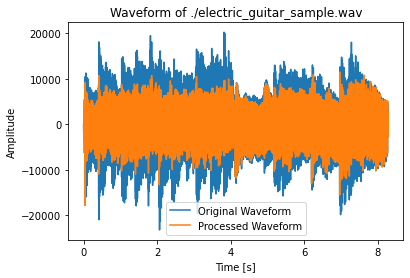

In [352]:
# now plot the output waveform THIS WILL TAKE A LONG TIME
print(guitar_effects.register_map.axilite_out)
print(guitar_effects.register_map.debug_output)
print(frames)
print(output_buffer)
# check if its all zeros so i can save some time
all_zeros = True
for sample in output_buffer:
    if sample != 0:
        all_zeros = False
        break
if all_zeros:
    raise ValueError("Function returned all zeros!")

plot_length = 1000000
plt.figure()
plt.legend(loc=1)
plt.plot(time[:plot_length], frames[:plot_length], label='Original Waveform')
plt.plot(time[:plot_length], output_buffer[:plot_length], label='Processed Waveform')

plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Waveform of ' + file_path)
plt.legend()
plt.show()

In [361]:
#save to a wave file
output_sounds = output_buffer.astype(np.int16) # make sure casting is the same
# save frames to .wav file
wavfile.write('outputs/hardware_result.wav', frame_rate, output_sounds)

# Measuring Speed of PS implementations

In [11]:
def distort(waveform: np.ndarray, threshold: int, clip_factor: float) -> list:
    """Distort the waveform by clipping the values above the threshold and below the negative threshold and softening the clipped values."""
    # This function will be replaced by HLS code
    distorted_waveform = waveform

    # apply clipping
    distorted_waveform = np.where(distorted_waveform > threshold, (distorted_waveform - threshold) * clip_factor + threshold, distorted_waveform)
    distorted_waveform = np.where(distorted_waveform <  -threshold, (distorted_waveform - threshold) * clip_factor - threshold, distorted_waveform)
    # print(type(waveform))
    # print(type(distorted_waveform))
    distorted_waveform = distorted_waveform.astype(np.int16)
    return distorted_waveform

In [13]:
# time the distortion algorithm

start = timer()

threshold = 5000
clip_factor = 0.5
output = distort(frames, threshold, clip_factor)

end = timer()

print(f"PS Distortion took {end - start} seconds")

PS Distortion took 0.3726034164428711 seconds


In [14]:
# Amplitude detection used in compression algorithm
# THIS USES A FIR LOW PASS FILTER

def detect_amplitude(waveform: np.array) -> list:
    """Returns a np.array of equal lenght corresponding to the amplitude of the waveform at that point."""
    # This function will be replaced by HLS code
    rectified_signal = np.abs(waveform)

    # now apply a low pass filter to the rectified signal to envelop detect
    filter_length = frame_rate // 200 # frame rate over lowest frequency
    filter = np.ones(filter_length) / filter_length # create a filter which will just average the signal over the filter length
    filter = filter * 3 # normalize to match amplitude of wave
    envelope = np.convolve(rectified_signal, filter, mode='same') # convolve filter with signal
    return envelope


In [15]:
# compression algorithm!

def compress(waveform: np.array, min_threshold: int, max_threshold: int, zero_threshold: int) -> list:
    """Compress the waveform by reducing the amplitude of the values above the threshold by the given ratio."""
    # This function will be replaced by HLS code
    envelope = detect_amplitude(waveform)
    compressed_waveform = list(waveform)
    # if sample is not loud enough, make louder, if too loud make quiter
    for i, sample in enumerate(compressed_waveform):
        if envelope[i] > max_threshold:
            compression_factor = envelope[i] / max_threshold
            compressed_waveform[i] = sample / compression_factor
        elif envelope[i] < min_threshold and envelope[i] > zero_threshold:
            compression_factor = min_threshold / envelope[i]
            compressed_waveform[i] = sample * compression_factor
    
    compressed_waveform = np.array(compressed_waveform, dtype="int16")
    return compressed_waveform

In [16]:
# time the compression algorithm

start = timer()

min_threshold = 2000
max_threshold = 3000
zero_threshold = 30
output = compress(frames, min_threshold, max_threshold, zero_threshold)

end = timer()

print(f"PS Compression took {end - start} seconds")

PS Compression took 51.389405965805054 seconds


In [38]:
# delay algorithm!!!
def delay(waveform: np.array, delay_samples: int, delay_gain: float) -> list:
    """Adds a delayed version of the waveform to itself with the given delay and gain."""
    # This function will be replaced by HLS code
    delayed_waveform = list(waveform)
    for i in range(delay_samples, len(waveform)):
        delayed_waveform[i] = delayed_waveform[i] + (delayed_waveform[i - delay_samples] * delay_gain)
    # cast as int16
    delayed_waveform = np.array(delayed_waveform, dtype="int16")
    return delayed_waveform

In [39]:
# time the compression algorithm

start = timer()

delay_samples = 1500
delay_gain = 0.5
output = delay(frames, delay_samples, delay_gain)
end = timer()

print(f"PS Delay took {end - start} seconds")

PS Delay took 41.66818451881409 seconds


In [18]:
# a function that takes in an audio waveform and applies a bandpass filter to it
def create_filter(lowcut, highcut, order):
    nyq_rate = frame_rate / 2.0
    low = lowcut / nyq_rate
    high = highcut / nyq_rate
    taps = np.arange(-order // 2, order // 2 + 1)
    filter_kernel = np.sinc(2 * high * taps) - np.sinc(2 * low * taps)
    window = np.hamming(order + 1)
    filter_kernel *= window
    filter_kernel /= np.sum(filter_kernel)
    # create window
    window = np.hamming(order + 1)
    filter_kernel *= window
    filter_kernel /= np.sum(filter_kernel)
    return filter_kernel

In [37]:
# wah effect
# basically a bandpass filter that will change center frequency based on an input signal
import math

frame_rate = 88200

def wah(waveform: np.array, filters, tempo) -> list:
    """Applies a wah effect to the waveform based on the control signal."""
    # apply the filter to the waveform
    # now basically convolve, but use a different BPF based on the control signal.
    wah_waveform = [0] * (len(waveform) + len(filters[0]) - 1)
    # iterate though waveform
    for i in range(len(waveform)):
        print("on sample", i)
        control_signal = math.floor(len(filters) * (0.5 + 0.5*(math.sin(0.104*i*tempo/frame_rate))))
        #iterate through kernal
        for j in range(len(filters[0])): # assuming filters are all the same length
            # convolve but only based on the control signal filter
            wah_waveform[i + j] += waveform[i] * filters[control_signal][j]
    #truncate to length of original waveform
    wah_waveform = wah_waveform[:len(waveform)]
    #make numpy
    wah_waveform = np.array(wah_waveform, dtype="int16")
    # Convolve the filter with the data
    wah_waveform = wah_waveform.astype(np.int16)
    return wah_waveform
    
    


In [38]:
# scale # ofvalues to save time
samples = 10000

# time wah effect 
min_freq = 200
max_freq = 2000
filter_count = 10
filter_order = 99
tempo = 140

# do all the stuff that hardware doesnt have to do
filters = [create_filter(min_freq + (max_freq - min_freq) * i / filter_count, min_freq + (max_freq - min_freq) * (i + 1) / filter_count, filter_order) for i in range(filter_count)]
filters = [filter[::-1] for filter in filters]
# change the input signal to an aray of values which will just be the index of the filter to use

start = timer()

output = wah(frames[:samples], filters, tempo)

end = timer()

time_mult = len(frames) / samples
print(f"PS Wah took {(end - start)*time_mult} seconds")

on sample 0
on sample 1
on sample 2
on sample 3
on sample 4
on sample 5
on sample 6
on sample 7
on sample 8
on sample 9
on sample 10
on sample 11
on sample 12
on sample 13
on sample 14
on sample 15
on sample 16
on sample 17
on sample 18
on sample 19
on sample 20
on sample 21
on sample 22
on sample 23
on sample 24
on sample 25
on sample 26
on sample 27
on sample 28
on sample 29
on sample 30
on sample 31
on sample 32
on sample 33
on sample 34
on sample 35
on sample 36
on sample 37
on sample 38
on sample 39
on sample 40
on sample 41
on sample 42
on sample 43
on sample 44
on sample 45
on sample 46
on sample 47
on sample 48
on sample 49
on sample 50
on sample 51
on sample 52
on sample 53
on sample 54
on sample 55
on sample 56
on sample 57
on sample 58
on sample 59
on sample 60
on sample 61
on sample 62
on sample 63
on sample 64
on sample 65
on sample 66
on sample 67
on sample 68
on sample 69
on sample 70
on sample 71
on sample 72
on sample 73
on sample 74
on sample 75
on sample 76
on sample

on sample 612
on sample 613
on sample 614
on sample 615
on sample 616
on sample 617
on sample 618
on sample 619
on sample 620
on sample 621
on sample 622
on sample 623
on sample 624
on sample 625
on sample 626
on sample 627
on sample 628
on sample 629
on sample 630
on sample 631
on sample 632
on sample 633
on sample 634
on sample 635
on sample 636
on sample 637
on sample 638
on sample 639
on sample 640
on sample 641
on sample 642
on sample 643
on sample 644
on sample 645
on sample 646
on sample 647
on sample 648
on sample 649
on sample 650
on sample 651
on sample 652
on sample 653
on sample 654
on sample 655
on sample 656
on sample 657
on sample 658
on sample 659
on sample 660
on sample 661
on sample 662
on sample 663
on sample 664
on sample 665
on sample 666
on sample 667
on sample 668
on sample 669
on sample 670
on sample 671
on sample 672
on sample 673
on sample 674
on sample 675
on sample 676
on sample 677
on sample 678
on sample 679
on sample 680
on sample 681
on sample 682
on sam

on sample 1210
on sample 1211
on sample 1212
on sample 1213
on sample 1214
on sample 1215
on sample 1216
on sample 1217
on sample 1218
on sample 1219
on sample 1220
on sample 1221
on sample 1222
on sample 1223
on sample 1224
on sample 1225
on sample 1226
on sample 1227
on sample 1228
on sample 1229
on sample 1230
on sample 1231
on sample 1232
on sample 1233
on sample 1234
on sample 1235
on sample 1236
on sample 1237
on sample 1238
on sample 1239
on sample 1240
on sample 1241
on sample 1242
on sample 1243
on sample 1244
on sample 1245
on sample 1246
on sample 1247
on sample 1248
on sample 1249
on sample 1250
on sample 1251
on sample 1252
on sample 1253
on sample 1254
on sample 1255
on sample 1256
on sample 1257
on sample 1258
on sample 1259
on sample 1260
on sample 1261
on sample 1262
on sample 1263
on sample 1264
on sample 1265
on sample 1266
on sample 1267
on sample 1268
on sample 1269
on sample 1270
on sample 1271
on sample 1272
on sample 1273
on sample 1274
on sample 1275
on sample 

on sample 1780
on sample 1781
on sample 1782
on sample 1783
on sample 1784
on sample 1785
on sample 1786
on sample 1787
on sample 1788
on sample 1789
on sample 1790
on sample 1791
on sample 1792
on sample 1793
on sample 1794
on sample 1795
on sample 1796
on sample 1797
on sample 1798
on sample 1799
on sample 1800
on sample 1801
on sample 1802
on sample 1803
on sample 1804
on sample 1805
on sample 1806
on sample 1807
on sample 1808
on sample 1809
on sample 1810
on sample 1811
on sample 1812
on sample 1813
on sample 1814
on sample 1815
on sample 1816
on sample 1817
on sample 1818
on sample 1819
on sample 1820
on sample 1821
on sample 1822
on sample 1823
on sample 1824
on sample 1825
on sample 1826
on sample 1827
on sample 1828
on sample 1829
on sample 1830
on sample 1831
on sample 1832
on sample 1833
on sample 1834
on sample 1835
on sample 1836
on sample 1837
on sample 1838
on sample 1839
on sample 1840
on sample 1841
on sample 1842
on sample 1843
on sample 1844
on sample 1845
on sample 

on sample 2341
on sample 2342
on sample 2343
on sample 2344
on sample 2345
on sample 2346
on sample 2347
on sample 2348
on sample 2349
on sample 2350
on sample 2351
on sample 2352
on sample 2353
on sample 2354
on sample 2355
on sample 2356
on sample 2357
on sample 2358
on sample 2359
on sample 2360
on sample 2361
on sample 2362
on sample 2363
on sample 2364
on sample 2365
on sample 2366
on sample 2367
on sample 2368
on sample 2369
on sample 2370
on sample 2371
on sample 2372
on sample 2373
on sample 2374
on sample 2375
on sample 2376
on sample 2377
on sample 2378
on sample 2379
on sample 2380
on sample 2381
on sample 2382
on sample 2383
on sample 2384
on sample 2385
on sample 2386
on sample 2387
on sample 2388
on sample 2389
on sample 2390
on sample 2391
on sample 2392
on sample 2393
on sample 2394
on sample 2395
on sample 2396
on sample 2397
on sample 2398
on sample 2399
on sample 2400
on sample 2401
on sample 2402
on sample 2403
on sample 2404
on sample 2405
on sample 2406
on sample 

on sample 2892
on sample 2893
on sample 2894
on sample 2895
on sample 2896
on sample 2897
on sample 2898
on sample 2899
on sample 2900
on sample 2901
on sample 2902
on sample 2903
on sample 2904
on sample 2905
on sample 2906
on sample 2907
on sample 2908
on sample 2909
on sample 2910
on sample 2911
on sample 2912
on sample 2913
on sample 2914
on sample 2915
on sample 2916
on sample 2917
on sample 2918
on sample 2919
on sample 2920
on sample 2921
on sample 2922
on sample 2923
on sample 2924
on sample 2925
on sample 2926
on sample 2927
on sample 2928
on sample 2929
on sample 2930
on sample 2931
on sample 2932
on sample 2933
on sample 2934
on sample 2935
on sample 2936
on sample 2937
on sample 2938
on sample 2939
on sample 2940
on sample 2941
on sample 2942
on sample 2943
on sample 2944
on sample 2945
on sample 2946
on sample 2947
on sample 2948
on sample 2949
on sample 2950
on sample 2951
on sample 2952
on sample 2953
on sample 2954
on sample 2955
on sample 2956
on sample 2957
on sample 

on sample 3451
on sample 3452
on sample 3453
on sample 3454
on sample 3455
on sample 3456
on sample 3457
on sample 3458
on sample 3459
on sample 3460
on sample 3461
on sample 3462
on sample 3463
on sample 3464
on sample 3465
on sample 3466
on sample 3467
on sample 3468
on sample 3469
on sample 3470
on sample 3471
on sample 3472
on sample 3473
on sample 3474
on sample 3475
on sample 3476
on sample 3477
on sample 3478
on sample 3479
on sample 3480
on sample 3481
on sample 3482
on sample 3483
on sample 3484
on sample 3485
on sample 3486
on sample 3487
on sample 3488
on sample 3489
on sample 3490
on sample 3491
on sample 3492
on sample 3493
on sample 3494
on sample 3495
on sample 3496
on sample 3497
on sample 3498
on sample 3499
on sample 3500
on sample 3501
on sample 3502
on sample 3503
on sample 3504
on sample 3505
on sample 3506
on sample 3507
on sample 3508
on sample 3509
on sample 3510
on sample 3511
on sample 3512
on sample 3513
on sample 3514
on sample 3515
on sample 3516
on sample 

on sample 4013
on sample 4014
on sample 4015
on sample 4016
on sample 4017
on sample 4018
on sample 4019
on sample 4020
on sample 4021
on sample 4022
on sample 4023
on sample 4024
on sample 4025
on sample 4026
on sample 4027
on sample 4028
on sample 4029
on sample 4030
on sample 4031
on sample 4032
on sample 4033
on sample 4034
on sample 4035
on sample 4036
on sample 4037
on sample 4038
on sample 4039
on sample 4040
on sample 4041
on sample 4042
on sample 4043
on sample 4044
on sample 4045
on sample 4046
on sample 4047
on sample 4048
on sample 4049
on sample 4050
on sample 4051
on sample 4052
on sample 4053
on sample 4054
on sample 4055
on sample 4056
on sample 4057
on sample 4058
on sample 4059
on sample 4060
on sample 4061
on sample 4062
on sample 4063
on sample 4064
on sample 4065
on sample 4066
on sample 4067
on sample 4068
on sample 4069
on sample 4070
on sample 4071
on sample 4072
on sample 4073
on sample 4074
on sample 4075
on sample 4076
on sample 4077
on sample 4078
on sample 

on sample 4561
on sample 4562
on sample 4563
on sample 4564
on sample 4565
on sample 4566
on sample 4567
on sample 4568
on sample 4569
on sample 4570
on sample 4571
on sample 4572
on sample 4573
on sample 4574
on sample 4575
on sample 4576
on sample 4577
on sample 4578
on sample 4579
on sample 4580
on sample 4581
on sample 4582
on sample 4583
on sample 4584
on sample 4585
on sample 4586
on sample 4587
on sample 4588
on sample 4589
on sample 4590
on sample 4591
on sample 4592
on sample 4593
on sample 4594
on sample 4595
on sample 4596
on sample 4597
on sample 4598
on sample 4599
on sample 4600
on sample 4601
on sample 4602
on sample 4603
on sample 4604
on sample 4605
on sample 4606
on sample 4607
on sample 4608
on sample 4609
on sample 4610
on sample 4611
on sample 4612
on sample 4613
on sample 4614
on sample 4615
on sample 4616
on sample 4617
on sample 4618
on sample 4619
on sample 4620
on sample 4621
on sample 4622
on sample 4623
on sample 4624
on sample 4625
on sample 4626
on sample 

on sample 5136
on sample 5137
on sample 5138
on sample 5139
on sample 5140
on sample 5141
on sample 5142
on sample 5143
on sample 5144
on sample 5145
on sample 5146
on sample 5147
on sample 5148
on sample 5149
on sample 5150
on sample 5151
on sample 5152
on sample 5153
on sample 5154
on sample 5155
on sample 5156
on sample 5157
on sample 5158
on sample 5159
on sample 5160
on sample 5161
on sample 5162
on sample 5163
on sample 5164
on sample 5165
on sample 5166
on sample 5167
on sample 5168
on sample 5169
on sample 5170
on sample 5171
on sample 5172
on sample 5173
on sample 5174
on sample 5175
on sample 5176
on sample 5177
on sample 5178
on sample 5179
on sample 5180
on sample 5181
on sample 5182
on sample 5183
on sample 5184
on sample 5185
on sample 5186
on sample 5187
on sample 5188
on sample 5189
on sample 5190
on sample 5191
on sample 5192
on sample 5193
on sample 5194
on sample 5195
on sample 5196
on sample 5197
on sample 5198
on sample 5199
on sample 5200
on sample 5201
on sample 

on sample 5718
on sample 5719
on sample 5720
on sample 5721
on sample 5722
on sample 5723
on sample 5724
on sample 5725
on sample 5726
on sample 5727
on sample 5728
on sample 5729
on sample 5730
on sample 5731
on sample 5732
on sample 5733
on sample 5734
on sample 5735
on sample 5736
on sample 5737
on sample 5738
on sample 5739
on sample 5740
on sample 5741
on sample 5742
on sample 5743
on sample 5744
on sample 5745
on sample 5746
on sample 5747
on sample 5748
on sample 5749
on sample 5750
on sample 5751
on sample 5752
on sample 5753
on sample 5754
on sample 5755
on sample 5756
on sample 5757
on sample 5758
on sample 5759
on sample 5760
on sample 5761
on sample 5762
on sample 5763
on sample 5764
on sample 5765
on sample 5766
on sample 5767
on sample 5768
on sample 5769
on sample 5770
on sample 5771
on sample 5772
on sample 5773
on sample 5774
on sample 5775
on sample 5776
on sample 5777
on sample 5778
on sample 5779
on sample 5780
on sample 5781
on sample 5782
on sample 5783
on sample 

on sample 6299
on sample 6300
on sample 6301
on sample 6302
on sample 6303
on sample 6304
on sample 6305
on sample 6306
on sample 6307
on sample 6308
on sample 6309
on sample 6310
on sample 6311
on sample 6312
on sample 6313
on sample 6314
on sample 6315
on sample 6316
on sample 6317
on sample 6318
on sample 6319
on sample 6320
on sample 6321
on sample 6322
on sample 6323
on sample 6324
on sample 6325
on sample 6326
on sample 6327
on sample 6328
on sample 6329
on sample 6330
on sample 6331
on sample 6332
on sample 6333
on sample 6334
on sample 6335
on sample 6336
on sample 6337
on sample 6338
on sample 6339
on sample 6340
on sample 6341
on sample 6342
on sample 6343
on sample 6344
on sample 6345
on sample 6346
on sample 6347
on sample 6348
on sample 6349
on sample 6350
on sample 6351
on sample 6352
on sample 6353
on sample 6354
on sample 6355
on sample 6356
on sample 6357
on sample 6358
on sample 6359
on sample 6360
on sample 6361
on sample 6362
on sample 6363
on sample 6364
on sample 

on sample 6870
on sample 6871
on sample 6872
on sample 6873
on sample 6874
on sample 6875
on sample 6876
on sample 6877
on sample 6878
on sample 6879
on sample 6880
on sample 6881
on sample 6882
on sample 6883
on sample 6884
on sample 6885
on sample 6886
on sample 6887
on sample 6888
on sample 6889
on sample 6890
on sample 6891
on sample 6892
on sample 6893
on sample 6894
on sample 6895
on sample 6896
on sample 6897
on sample 6898
on sample 6899
on sample 6900
on sample 6901
on sample 6902
on sample 6903
on sample 6904
on sample 6905
on sample 6906
on sample 6907
on sample 6908
on sample 6909
on sample 6910
on sample 6911
on sample 6912
on sample 6913
on sample 6914
on sample 6915
on sample 6916
on sample 6917
on sample 6918
on sample 6919
on sample 6920
on sample 6921
on sample 6922
on sample 6923
on sample 6924
on sample 6925
on sample 6926
on sample 6927
on sample 6928
on sample 6929
on sample 6930
on sample 6931
on sample 6932
on sample 6933
on sample 6934
on sample 6935
on sample 

on sample 7428
on sample 7429
on sample 7430
on sample 7431
on sample 7432
on sample 7433
on sample 7434
on sample 7435
on sample 7436
on sample 7437
on sample 7438
on sample 7439
on sample 7440
on sample 7441
on sample 7442
on sample 7443
on sample 7444
on sample 7445
on sample 7446
on sample 7447
on sample 7448
on sample 7449
on sample 7450
on sample 7451
on sample 7452
on sample 7453
on sample 7454
on sample 7455
on sample 7456
on sample 7457
on sample 7458
on sample 7459
on sample 7460
on sample 7461
on sample 7462
on sample 7463
on sample 7464
on sample 7465
on sample 7466
on sample 7467
on sample 7468
on sample 7469
on sample 7470
on sample 7471
on sample 7472
on sample 7473
on sample 7474
on sample 7475
on sample 7476
on sample 7477
on sample 7478
on sample 7479
on sample 7480
on sample 7481
on sample 7482
on sample 7483
on sample 7484
on sample 7485
on sample 7486
on sample 7487
on sample 7488
on sample 7489
on sample 7490
on sample 7491
on sample 7492
on sample 7493
on sample 

on sample 8009
on sample 8010
on sample 8011
on sample 8012
on sample 8013
on sample 8014
on sample 8015
on sample 8016
on sample 8017
on sample 8018
on sample 8019
on sample 8020
on sample 8021
on sample 8022
on sample 8023
on sample 8024
on sample 8025
on sample 8026
on sample 8027
on sample 8028
on sample 8029
on sample 8030
on sample 8031
on sample 8032
on sample 8033
on sample 8034
on sample 8035
on sample 8036
on sample 8037
on sample 8038
on sample 8039
on sample 8040
on sample 8041
on sample 8042
on sample 8043
on sample 8044
on sample 8045
on sample 8046
on sample 8047
on sample 8048
on sample 8049
on sample 8050
on sample 8051
on sample 8052
on sample 8053
on sample 8054
on sample 8055
on sample 8056
on sample 8057
on sample 8058
on sample 8059
on sample 8060
on sample 8061
on sample 8062
on sample 8063
on sample 8064
on sample 8065
on sample 8066
on sample 8067
on sample 8068
on sample 8069
on sample 8070
on sample 8071
on sample 8072
on sample 8073
on sample 8074
on sample 

on sample 8577
on sample 8578
on sample 8579
on sample 8580
on sample 8581
on sample 8582
on sample 8583
on sample 8584
on sample 8585
on sample 8586
on sample 8587
on sample 8588
on sample 8589
on sample 8590
on sample 8591
on sample 8592
on sample 8593
on sample 8594
on sample 8595
on sample 8596
on sample 8597
on sample 8598
on sample 8599
on sample 8600
on sample 8601
on sample 8602
on sample 8603
on sample 8604
on sample 8605
on sample 8606
on sample 8607
on sample 8608
on sample 8609
on sample 8610
on sample 8611
on sample 8612
on sample 8613
on sample 8614
on sample 8615
on sample 8616
on sample 8617
on sample 8618
on sample 8619
on sample 8620
on sample 8621
on sample 8622
on sample 8623
on sample 8624
on sample 8625
on sample 8626
on sample 8627
on sample 8628
on sample 8629
on sample 8630
on sample 8631
on sample 8632
on sample 8633
on sample 8634
on sample 8635
on sample 8636
on sample 8637
on sample 8638
on sample 8639
on sample 8640
on sample 8641
on sample 8642
on sample 

on sample 9142
on sample 9143
on sample 9144
on sample 9145
on sample 9146
on sample 9147
on sample 9148
on sample 9149
on sample 9150
on sample 9151
on sample 9152
on sample 9153
on sample 9154
on sample 9155
on sample 9156
on sample 9157
on sample 9158
on sample 9159
on sample 9160
on sample 9161
on sample 9162
on sample 9163
on sample 9164
on sample 9165
on sample 9166
on sample 9167
on sample 9168
on sample 9169
on sample 9170
on sample 9171
on sample 9172
on sample 9173
on sample 9174
on sample 9175
on sample 9176
on sample 9177
on sample 9178
on sample 9179
on sample 9180
on sample 9181
on sample 9182
on sample 9183
on sample 9184
on sample 9185
on sample 9186
on sample 9187
on sample 9188
on sample 9189
on sample 9190
on sample 9191
on sample 9192
on sample 9193
on sample 9194
on sample 9195
on sample 9196
on sample 9197
on sample 9198
on sample 9199
on sample 9200
on sample 9201
on sample 9202
on sample 9203
on sample 9204
on sample 9205
on sample 9206
on sample 9207
on sample 

on sample 9704
on sample 9705
on sample 9706
on sample 9707
on sample 9708
on sample 9709
on sample 9710
on sample 9711
on sample 9712
on sample 9713
on sample 9714
on sample 9715
on sample 9716
on sample 9717
on sample 9718
on sample 9719
on sample 9720
on sample 9721
on sample 9722
on sample 9723
on sample 9724
on sample 9725
on sample 9726
on sample 9727
on sample 9728
on sample 9729
on sample 9730
on sample 9731
on sample 9732
on sample 9733
on sample 9734
on sample 9735
on sample 9736
on sample 9737
on sample 9738
on sample 9739
on sample 9740
on sample 9741
on sample 9742
on sample 9743
on sample 9744
on sample 9745
on sample 9746
on sample 9747
on sample 9748
on sample 9749
on sample 9750
on sample 9751
on sample 9752
on sample 9753
on sample 9754
on sample 9755
on sample 9756
on sample 9757
on sample 9758
on sample 9759
on sample 9760
on sample 9761
on sample 9762
on sample 9763
on sample 9764
on sample 9765
on sample 9766
on sample 9767
on sample 9768
on sample 9769
on sample 